<left>
<img src="idc_logo.png" width=100 align="left">
</left>

<H4>Advanced Stats. for Data Science (Spring 2022)</H4>

<H1>Examples from Lecture 9 </H1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import scipy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt



np.random.seed(2021)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 18})
%matplotlib inline

# Simple Regression

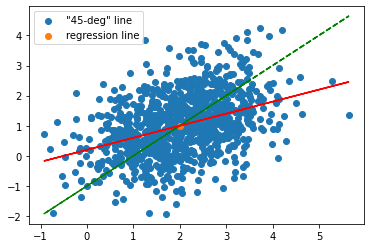

In [2]:
from scipy.stats import norm

rho = .4
sigX = 1
sigY = 1

mu_X = 2
mu_Y = 1

n = 1000

z = norm.rvs(size=(n, 2)).T
Sig = np.array([[sigX ** 2, sigX * sigY * rho],
                [sigX * sigY * rho, sigY ** 2]])
Sig_sqrt = np.linalg.cholesky(Sig)
x, y = np.array([[mu_X, mu_Y]]).T + Sig_sqrt @ z

plt.scatter(x, y)
plt.scatter(mu_X, mu_Y)

y_deg45 = mu_Y + sigY/sigX * (x - mu_X)
plt.plot(x, y_deg45, '--g')  # "45deg line"

y_reg = mu_Y + rho*sigY/sigX * (x - mu_X) # regression line
plt.plot(x, y_reg, 'r')
plt.legend(['"45-deg" line', 'regression line'])
plt.savefig("regression.png")
plt.show()

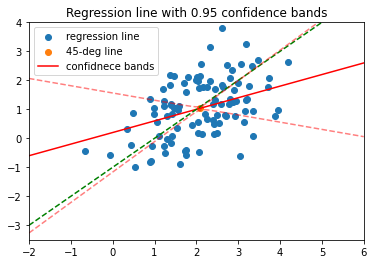

In [3]:
from scipy.stats import t

rho = .4
sigX = 1
sigY = 1

mu_X = 2
mu_Y = 1

n = 100

sig_level = 0.05

z = norm.rvs(size=(n, 2)).T
Sig = np.array([[sigX ** 2, sigX * sigY * rho],
                [sigX * sigY * rho, sigY ** 2]])
Sig_sqrt = np.linalg.cholesky(Sig)
x, y = np.array([[mu_X, mu_Y]]).T + Sig_sqrt @ z

plt.scatter(x, y)
plt.scatter(x.mean(), y.mean())

y_hat = mu_Y + rho*sigY/sigX * (x - mu_X)

xx = np.linspace(-2, 6, 100)

y_reg = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line
y_deg45 = mu_Y + sigY/sigX * (xx - mu_X)

plt.plot(xx, y_reg, 'r')
plt.plot(xx, y_deg45, '--g')

t_alpha = t.isf(.05 / 2, df = n-2)

s2 = np.linalg.norm(y - y_hat)/(n-2)
Sxx = np.mean((x - np.mean(x))**2)


y_reg2 = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line
y_band = t_alpha * np.sqrt(s2) * np.sqrt(1/n + (xx - np.mean(x))**2/Sxx )

plt.plot(xx, y_reg2 + y_band, '--r', alpha=.5)
plt.plot(xx, y_reg2 - y_band, '--r', alpha=.5)
plt.xlim((-2, 6))
plt.ylim((-3.5, 4))

plt.title(f"Regression line with {1-sig_level} confidence bands")
plt.legend(['regression line', '45-deg line', 'confidnece bands'])
plt.savefig("confidence_band.png")
plt.show()

### Prediction bands
We want to predict $y_{n+1}$ given $x_{n+1}$ and $(y_i,x_i)$, for $i=1,\ldots,n$.

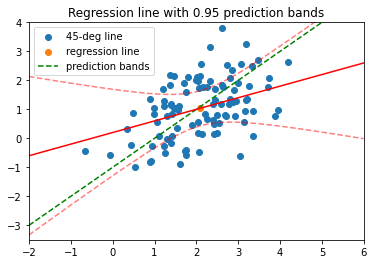

In [4]:
from scipy.stats import t

plt.scatter(x, y)
plt.scatter(x.mean(), y.mean())

plt.plot([mu_X - 4, mu_X+4], [mu_Y-4, mu_Y+4], '--g')  # "45deg line"

y_hat = mu_Y + rho*sigY/sigX * (x - mu_X)  # regression value for every x

xx = np.linspace(-2, 6, 100)
y_reg = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line

plt.plot(xx, y_reg, 'r')

t_alpha = t.isf(sig_level / 2, df = n-2)

s2 = np.linalg.norm(y - y_hat)/(n-2)
Sxx = np.mean((x - np.mean(x))**2)


y_reg2 = mu_Y + rho*sigY/sigX * (xx - mu_X) # regression line
y_band = t_alpha * np.sqrt(s2) * np.sqrt(1 + 1/n + (xx - np.mean(x))**2/Sxx )

plt.plot(xx, y_reg2 + y_band, '--r', alpha=.5)
plt.plot(xx, y_reg2 - y_band, '--r', alpha=.5)
plt.xlim((-2, 6))
plt.ylim((-3.5, 4))

plt.title(f"Regression line with {1-sig_level} prediction bands")
plt.legend(['45-deg line', 'regression line', 'prediction bands'])
plt.savefig("prediction_band.png")
plt.show()

# Multiple Regression (House Prices)

In [5]:
# 
data = pd.read_csv("housing_prices.csv")
data = data[data.LotArea < 15000]  # we focus on small lots
data['h-MSZoning'] = data.MSZoning.apply(hash) # convert this categorical data to numeric

In [6]:
data1 = data.select_dtypes('number').dropna()\
            .rename(columns = {'1stFlrSF': 'FirstFlrSF',
                              '2ndFlrSF': 'SecondFlrSF'}) # stats model formula cannot have
                                                          # covaraite names starting with non letter

variables =[
    'SalePrice',
    'LotArea', 
    'YearBuilt',
    #'LandSlope',
     'YrSold', 'MoSold', 
     'Fireplaces', 
    'GarageCars', 'ScreenPorch', 
     'HalfBath', 'FullBath',
     'GrLivArea', 
     'BedroomAbvGr',
    'FirstFlrSF', 
    'SecondFlrSF',
    'TotRmsAbvGrd',
    'LowQualFinSF', 'TotalBsmtSF',
    'LotFrontage', 'WoodDeckSF',
     'OverallQual',
     'OverallCond'
]

data1 = data1.filter(variables).dropna()
data1['logSalePrice'] = np.log(data1['SalePrice'])
data1.shape

(1042, 22)

In [7]:
def detect_outliers(df, q=0.05):
    lower_outliers = df < df.quantile(q)
    upper_outliers = df > df.quantile(1-q)
    return lower_outliers + upper_outliers

mask = detect_outliers(data1, .01).any(1)
print(f"Masked a fraction of {mask.mean()} of the data due to outliers")
data2 = data1[~mask]


#pd.plotting.scatter_matrix(data2, hist_kwds={'bins':30})
#plt.show()
#plt.rcParams["figure.figsize"] = (10,5)
#plt.rcParams.update({'font.size': 18})
data2.shape

Masked a fraction of 0.14971209213051823 of the data due to outliers


(886, 22)

In [8]:
import statsmodels.formula.api as smf

covariates = [var for var in variables if var not in ['SalePrice', 'logSalePrice']]

target = 'SalePrice'
model = smf.ols(formula= target + " ~ " + " + ".join(covariates), data=data2).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                   OLS                  Adj. R-squared:         0.843     
Dependent Variable:      SalePrice            AIC:                    20453.6755
Date:                    2022-06-12 12:57     BIC:                    20549.4099
No. Observations:        886                  Log-Likelihood:         -10207.   
Df Model:                19                   F-statistic:            251.8     
Df Residuals:            866                  Prob (F-statistic):     0.00      
R-squared:               0.847                Scale:                  6.0772e+08
--------------------------------------------------------------------------------
                 Coef.       Std.Err.      t    P>|t|      [0.025       0.975]  
--------------------------------------------------------------------------------
Intercept    -1736936.2032 1285650.0223 -1.3510 0.1770 -4260290.6240 786418.2175
LotArea             1.9809       0.4609  4.2978 0.0000        1.0762      2.8855
YearBuilt         519.7652      51.2746 10.1369 0.0000      419.1281    620.4022
YrSold            309.7052     638.3324  0.4852 0.6277     -943.1544   1562.5648
MoSold            534.8113     322.3107  1.6593 0.0974      -97.7902   1167.4128
Fireplaces       2676.7436    1681.2821  1.5921 0.1117     -623.1208   5976.6080
GarageCars      10113.3147    1903.5591  5.3128 0.0000     6377.1858  13849.4436
ScreenPorch        27.9151      19.8990  1.4028 0.1610      -11.1408     66.9711
HalfBath         1103.8335    2710.7333  0.4072 0.6840    -4216.5421   6424.2090
FullBath        -6479.9732    2730.7801 -2.3729 0.0179   -11839.6947  -1120.2517
GrLivArea          12.5761      46.1997  0.2722 0.7855      -78.1003    103.2525
BedroomAbvGr   -11562.9876    1780.5746 -6.4940 0.0000   -15057.7340  -8068.2413
FirstFlrSF         47.0992      46.1545  1.0205 0.3078      -43.4885    137.6869
SecondFlrSF        46.7179      46.1956  1.0113 0.3122      -43.9505    137.3863
TotRmsAbvGrd      384.2304    1208.9006  0.3178 0.7507    -1988.4874   2756.9483
LowQualFinSF      -81.2409     138.2214 -0.5878 0.5568     -352.5291    190.0472
TotalBsmtSF        29.6377       4.0990  7.2304 0.0000       21.5924     37.6829
LotFrontage       163.0971      69.3250  2.3526 0.0189       27.0324    299.1618
WoodDeckSF         32.1057       8.4347  3.8064 0.0002       15.5508     48.6605
OverallQual     14940.2231    1138.8718 13.1184 0.0000    12704.9514  17175.4949
OverallCond      7372.9255     985.2869  7.4830 0.0000     5439.0958   9306.7552
--------------------------------------------------------------------------------
Omnibus:               131.668        Durbin-Watson:           2.048            
Prob(Omnibus):         0.000          Jarque-Bera (JB):        838.164          
Skew:                  0.488          Prob(JB):                0.000            
Kurtosis:              7.664          Condition No.:           80872771785637312
================================================================================
* The condition number is large (8e+16). This might indicate             strong
multicollinearity or other numerical problems.
"""

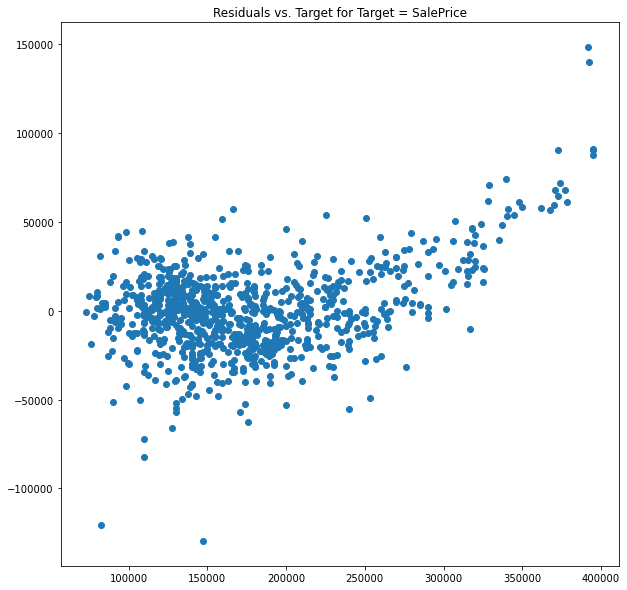

In [9]:
plt.rcParams['figure.figsize'] =  [10, 10]
plt.rcParams.update({'font.size': 10})

plt.scatter(data2.SalePrice, model.resid)
plt.title(f"Residuals vs. Target for Target = {target}")
plt.show()

The increased residuals for large values of the target usually indicates unstable variance (growing with value). A variance-stabilizing transformation is a good idea in this case.


R^2 = 0.881336756948791


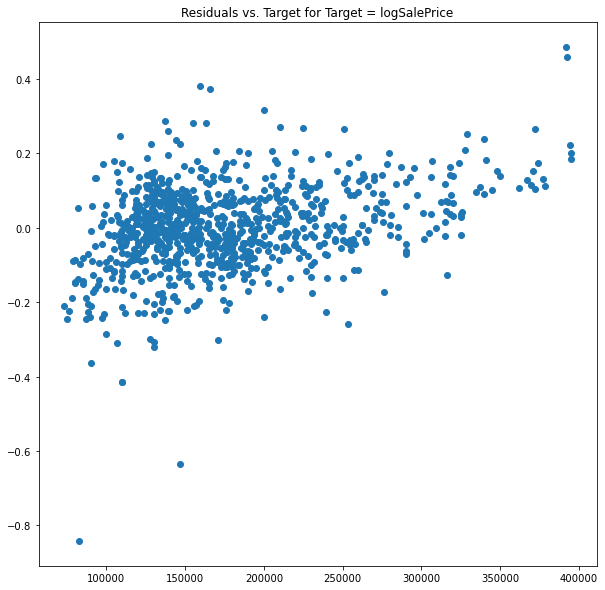

In [10]:

target = 'logSalePrice'
model2 = smf.ols(formula= target + " ~ " + " + ".join(covariates), data=data2).fit()
print(f"R^2 = {model2.rsquared}")

plt.scatter(data2.SalePrice, model2.resid)

plt.title(f"Residuals vs. Target for Target = {target}")
plt.show()



### Face value interpertation 
Missleading for ``FullBath`` and ``BedroomAbvGr``

### Interplay:
Correlation between ``OverallQual`` and ``OverallCond``


### Partial Correlation

In this example we want to ask whether the number of fireplaces affects positively on the price of a house, so that we know to build some in order to increase the value of ours. However, what if the number of fireplaces is merely a function of the number of rooms which responsible to the increase. In this case, adding additional fireplaces would not affect the price (becasue we did not changed the number of rooms). To account for the effect of fireplaces, we can adjust for the number of rooms. 

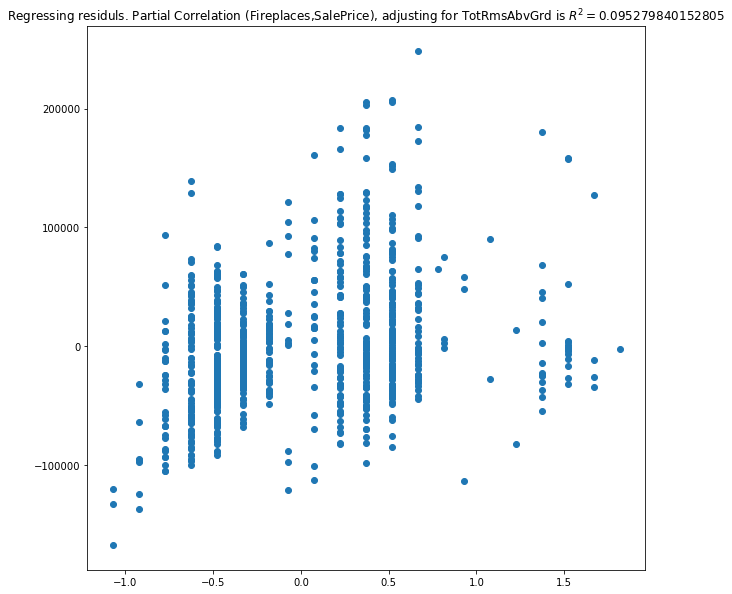

In [11]:
import statsmodels.api as sm

varX = 'Fireplaces'
varY = 'SalePrice'
varZ = 'TotRmsAbvGrd' # total rooms above ground level

model_LotFrontageYearBuilt = smf.ols(formula= f"{varX} ~ {varZ}", data=data2).fit()
model_SalePriceYearBuilt = smf.ols(formula= f"{varY} ~ {varZ}", data=data2).fit()

X = sm.add_constant(model_LotFrontageYearBuilt.resid)
y = model_SalePriceYearBuilt.resid
model_res = sm.OLS(y, X).fit()
plt.scatter(model_LotFrontageYearBuilt.resid, model_SalePriceYearBuilt.resid)
plt.title(fr"Regressing residuls. Partial Correlation ({varX},{varY}), adjusting for {varZ} is $R^2 = {model_res.rsquared}$")
plt.show()


In [19]:
model_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.094     
Dependent Variable: y                AIC:                21764.2985
Date:               2022-06-05 19:06 BIC:                21773.8719
No. Observations:   886              Log-Likelihood:     -10880.   
Df Model:           1                F-statistic:        93.10     
Df Residuals:       884              Prob (F-statistic): 5.17e-21  
R-squared:          0.095            Scale:              2.7217e+09
--------------------------------------------------------------------
         Coef.      Std.Err.    t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
const      0.0000  1752.6971  0.0000  1.0000  -3439.9331   3439.9331
0      30583.4486  3169.6911  9.6487  0.0000  24362.4506  36804.4466
-------------------------------------------------------------------
Omnibus:              108.152       Durbin-Watson:          2.115  
Prob(Omnibus):        0.000         Jarque-Bera (JB):       168.244
Skew:                 0.833         Prob(JB):               0.000  
Kurtosis:             4.336         Condition No.:          2      
===================================================================

"""

In [20]:
target = 'SalePrice'
y = data2[target].values
X = data2.drop(target, axis=1)
Z = np.concatenate([np.ones((len(X), 1)).T, X.T]).T

beta_hat, res, rnk, s =  np.linalg.lstsq(Z, y, rcond=None)
print("beta_hat (lstsq) = ", beta_hat)
y_hat = Z @ beta_hat
e_hat = y - y_hat

SStot = np.sum( (y - np.mean(y)) **2 )
SSfit = np.sum( (y_hat - np.mean(y)) **2 )
print(f"R^2 = {SSfit / SStot}")

beta_hat (lstsq) =  [-3.00055324e+06 -1.31118753e-01 -1.60115150e+02  6.26666563e+02
  1.37897002e+02 -2.40101600e+03  3.59202254e+03 -1.63674368e+01
 -4.60457952e+03 -6.75077982e+03  9.87456534e+00 -4.99598361e+03
 -3.55941036e+00 -3.92624637e+00  1.15298367e+03  1.73602969e+01
 -2.53655271e+00  4.38018765e+01  8.72065745e+00  1.24080763e+03
 -3.55445717e+03  1.87221699e+05]
R^2 = 0.9656199876024233
